![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/quickstart-ci/AzureMLin10mins.png)

# Train and deploy a model in Azure Machine Learning

## Import Data

* Download the MNIST dataset
* Display some sample images

In [1]:
import os
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), "/tmp/qs_data")
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

### Take a look at the data


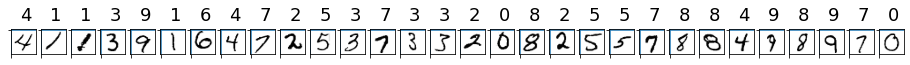

In [2]:
from utils import load_data
import matplotlib.pyplot as plt
import numpy as np
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = (
    load_data(
        glob.glob(
            os.path.join(data_folder, "**/train-images-idx3-ubyte.gz"), recursive=True
        )[0],
        False,
    )
    / 255.0
)
X_test = (
    load_data(
        glob.glob(
            os.path.join(data_folder, "**/t10k-images-idx3-ubyte.gz"), recursive=True
        )[0],
        False,
    )
    / 255.0
)
y_train = load_data(
    glob.glob(
        os.path.join(data_folder, "**/train-labels-idx1-ubyte.gz"), recursive=True
    )[0],
    True,
).reshape(-1)
y_test = load_data(
    glob.glob(
        os.path.join(data_folder, "**/t10k-labels-idx1-ubyte.gz"), recursive=True
    )[0],
    True,
).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline("")
    plt.axvline("")
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Train model and log metrics with MLflow

Train the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from the [SciKit Learn framework](https://scikit-learn.org/) to classify the data.



In [3]:
# create the model
import mlflow
import numpy as np
from sklearn.linear_model import LogisticRegression
from azureml.core import Workspace

# connect to your workspace
ws = Workspace.from_config()

# create experiment and start logging to a new run in the experiment
experiment_name = "azure-ml-in10-mins-tutorial"

# set up MLflow to track the metrics
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)
mlflow.autolog()

# set up the Logistic regression model
reg = 0.5
clf = LogisticRegression(
    C=1.0 / reg, solver="liblinear", multi_class="auto", random_state=42
)

# train the model
with mlflow.start_run() as run:
    clf.fit(X_train, y_train)

2022/08/06 17:06:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/08/06 17:06:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/08/06 17:06:18 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/08/06 17:06:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


## View Experiment
In the left-hand menu in Azure Machine Learning Studio, select __Experiments__ and then select your experiment.

## Version control your models with the model registry

Once you have executed the code cell below you will be able to see the model in the registry by selecting __Models__ in the left-hand menu in Azure Machine Learning Studio.Registered models are identified by name and version. Each time you register a model with the same name as an existing one, the registry increments the version. 

In [4]:
# register the model
model_uri = "runs:/{}/model".format(run.info.run_id)
model = mlflow.register_model(model_uri, "sklearn_mnist_model")

Registered model 'sklearn_mnist_model' already exists. Creating a new version of this model...
2022/08/06 17:09:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sklearn_mnist_model, version 4
Created version '4' of model 'sklearn_mnist_model'.


## Deploy the model for real-time inference
Deploy a model so that an application can consume (inference) the model over REST.

### Create deployment configuration

In [5]:
# create environment for the deploy
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.webservice import AciWebservice

# get a curated environment
env = Environment.get(
    workspace=ws, 
    name="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu",
    version=1
)
env.inferencing_stack_version='latest'

# create deployment config i.e. compute resources
aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={"data": "MNIST", "method": "sklearn"},
    description="Predict MNIST with sklearn",
)

### Deploy model

Deploy the model to Azure Container Instance (ACI).

In [6]:
%%time
import uuid
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.model import Model

# get the registered model
model = Model(ws, "sklearn_mnist_model")

# create an inference config i.e. the scoring script and environment
inference_config = InferenceConfig(entry_script="score.py", environment=env)

# deploy the service
service_name = "sklearn-mnist-svc-" + str(uuid.uuid4())[:4]
service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig,
)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-08-06 17:09:04+00:00 Creating Container Registry if not exists.
2022-08-06 17:09:05+00:00 Registering the environment.
2022-08-06 17:09:05+00:00 Use the existing image.
2022-08-06 17:09:05+00:00 Generating deployment configuration.
2022-08-06 17:09:06+00:00 Submitting deployment to compute.
2022-08-06 17:09:13+00:00 Checking the status of deployment sklearn-mnist-svc-53b4..
2022-08-06 17:12:18+00:00 Checking the status of inference endpoint sklearn-mnist-svc-53b4.
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 1.13 s, sys: 134 ms, total: 1.26 s
Wall time: 4min 38s


## Test the model service

Test the model by sending a raw HTTP request to test the web service. 

In [7]:
# send raw HTTP request to test the web service.
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test) - 1)
input_data = '{"data": [' + str(list(X_test[random_index])) + "]}"

headers = {"Content-Type": "application/json"}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://7aa2b8fb-61ec-4f78-b9b7-71986888ff2b.westeurope.azurecontainer.io/score
label: 4
prediction: [4]


## Clean up resources

If you want to keep workspace and only delete endpoint, delete the Model service using:

In [8]:
service.delete()